In [1]:
# Data Manipulating and Visualization
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize
import random


# Operating System
import os
from datetime import datetime

# Machine Learning Algorithms
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# Performance metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

# Hyperparameter
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

## Mathematics and Statistics
import scipy.stats as stats
from scipy.stats import uniform
from scipy.stats import loguniform

# NLP related 
import string
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer


# 1. Load modeling data
### [The creation of the the modeling data is discussed in this notebook](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/imdb_data.ipynb)


In [2]:
Modeling_Date = pd.read_csv('/kaggle/input/imdb-date/Modeling_Date.csv',low_memory=False)

In [3]:
X_Data = Modeling_Date.drop(['movie_review','sentiment_label','sentiment_number'], axis=1)
Y_Data = Modeling_Date.sentiment_number

# 2. Feature Selection
### This study conducted and compared two feature selection approaches: the (1)"Iterative Reduction (IR)" approach, and the (2) Boruta approach. 
* #### Algorithms: 
There are many machine learning algorithms to choose from, and here I have chosen the Light Gradient Boosting Model. The function [lightgbm.LGBMClassifier()](https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier) is used. The early stopping method is applied (the original data is randomly split into a new training set and a validation set). 

* #### Feature Importance Type: 
These two methods are closely related to feature importance, so different feature importance metrics may yield different results. Several common types of importance types are considered. In this notebook, we only consider the [gain](https://eli5.readthedocs.io/en/latest/libraries/lightgbm.html) importance.

* #### Hyperparameter: 
During the feature selection process, various models with different features will be estimated and compared. In this process, I will not tune hyperparameters but will use pre-specified hyperparameters. Hyperparameter tuning will be performed after the final feature list is determined.

* #### Performance Metrics: 
Logloss is considered. 

## **(1) Iterative Reduction (IR)**
### In this approach, the models are evolving as ‘less important’ features are removed. And the feature list (hence the feature important list) is updated whenever a new model is trained. The steps of the IR approach are described as the following:
* #### Assuming we start from 2000 features, a model with 2000 features is built, call it Model_2000, and the feature important list of this model is List_2000 is calculated.
* #### The Model_1900 is built using the top 1900 features in List_2000, and a new feature list List_1900 is calculated. 
* #### The Model_1800 is built using the top 1800 features in List_1900, and a new feature list List_1800 is calculated. 
* #### So on and so forth. In the end we obtain several models with different feature list, containing decreasing number of features. In general the final feature list is selected from the model with the best performance among these models. 



## **(2) Boruta**
### [This article](https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a) provides a description of the general idea of Boruta
### The steps of the Boruta approach are described as the following:
- #### Step 1: Assuming we start from 2000 features. Create a shadow feature for each feature (the shadow feature for X1 is a random shuffle of the initial X1). 
- #### Step 2: Build a “Boruta” model using all the 2000 original features and the 2000 shadow features created in Step 1. Note that in this step, the Boruta model can use different algorithms. We considered light gradient boosting, extreme gradient boosting, and random forest. 
- #### Step 3: Calculate the feature importance of each feature in the “Boruta” model built in Step 2. We considered several types of feature importance. Then calculate the number of “Hit” for each original features. A feature gets a “Hit” if its importance is higher than the most importance shadow feature. 
- #### Step 4: Repeat Step 1-3 many (such as 100) times. 
- #### Step 5: Finally, select a threshold of the number of Hits “h”, and keep all the features with number of “Hits”>h. 


## **Settings**
### Hyperparameters for LGB


In [4]:
params_LGB= {'boosting_type'    : 'gbdt',
             'objective'        : 'binary',
             'colsample_bytree' : 0.2,
             'learning_rate'    : 0.05,
             'min_child_samples': 10,
             'min_child_weight' : 5,
             'max_depth'        : -1,
             'min_split_gain'   : 0,
             'num_leaves'       : 31,
             'subsample_for_bin': 50000,
             'subsample_freq'   : 1,
             'n_estimators'     : 5000
}

## 2.1 Iterative Reduction Approch


### First, run a LGB model using all the features, and look at the feature importance of this model.

In [5]:
x1,x2,y1,y2 = train_test_split(X_Data,Y_Data,test_size = 0.3,random_state = 42)

In [6]:
LGB_2000 = lgb.LGBMClassifier(**params_LGB,importance_type='gain')
LGB_2000.fit(X = x1, y = y1,
             eval_metric=['logloss'], eval_set=[(x1,y1),(x2,y2)],
             callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])
importance_df = pd.DataFrame(list(x1)).rename(columns={0:'Features'})
importance_df['importance'] = LGB_2000.feature_importances_
importance_df = importance_df.sort_values(by=['importance'],ascending=False)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1055]	training's binary_logloss: 0.122556	valid_1's binary_logloss: 0.295978


### In fact, there are quite a few features with a gain/split importance of 0. It typically means that the feature did not contribute to the model's predictive performance during the training process. 
- #### A feature with zero "gain"/"split" importance means it was not selected as the splitting feature at any node during the construction of the ensemble of decision trees. 
- #### If a feature's split importance is 0, its gain importance is also 0. 

### As shown below, there are 261 features with positive gain/split importance scores. 
- #### So, in the first iteration, we reduce the number from 2000 to 261. 
- #### Then continued to gradually decrease the number of features.

In [7]:
importance_df[importance_df['importance']>0]

,Features,importance
160,bad,18180.554622
1978,worst,12578.323444
1923,wast,12302.281613
797,great,9692.643652
151,aw,9274.292484
...,...,...
1553,sentiment,1.681140
438,cross,1.514130
1074,lynch,1.461890
1158,moor,1.215910


### The following codes perform the IR approach

In [8]:
def Run_IR(params_LGB,importance_type,x1,x2,y1,y2,n_feature_list):
    def get_importance_from_LGBM(model,x_data,importance_type):
        ### Get the feature importance list, merge with the columns names, and sorted by the importance score. 
        importance_df = pd.DataFrame(list(x_data)).rename(columns={0:'Features'})
        importance_df[importance_type] = model.feature_importances_
        importance_df = importance_df.sort_values(by=[importance_type],ascending=False)
        return importance_df

    def iterative_reduction(start_n,end_n,importance_dict):
        print('Feature reduction from %d to %d ...' %(start_n,end_n))
        importance_old = importance_dict['importance_'+str(start_n)]
        Selected_Features = importance_old.head(end_n)['Features'].values.tolist()
        Shuffled_Features = Selected_Features.copy()
        random.shuffle(Shuffled_Features)
        x1_new = x1[Shuffled_Features]
        x2_new = x2[Shuffled_Features]
        
        LGB_now = lgb.LGBMClassifier(**params_LGB,importance_type=importance_type)
        LGB_now.fit(X = x1_new, y = y1,
                    eval_metric=['logloss'], eval_set=[(x1_new,y1),(x2_new,y2)],
                    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])
        importance_now = get_importance_from_LGBM(LGB_now,x1_new,importance_type)
        
        updated_importance_dict = importance_dict.copy()
        updated_importance_dict['importance_'+str(end_n)] = importance_now
        return(updated_importance_dict)

    ##### Create a dict to store the importance list
    importance_dict   = {}
    
    ##### First iteration (including all the features considered)
    LGB_2000 = lgb.LGBMClassifier(**params_LGB,importance_type=importance_type)
    LGB_2000.fit(X = x1, y = y1,
                 eval_metric=['auc','logloss'], eval_set=[(x1,y1),(x2,y2)],
                 callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])
    importance_2000 = get_importance_from_LGBM(LGB_2000,x1,importance_type)
    importance_dict['importance_2000'] = importance_2000
    
    ##### Run Iteration Reduction
    for a in range(len(n_feature_list)-1):
        importance_dict = iterative_reduction(n_feature_list[a], n_feature_list[a+1],importance_dict)
    
    ##### Create a dict to store the feature list
    feature_list_dict = {}
    for i in range(len(n_feature_list)):
        temp = importance_dict['importance_'+str(n_feature_list[i])]
        feature_list_dict['fl_ir_'+str(n_feature_list[i])] = temp['Features']
    
    return feature_list_dict

#### IR with **Gain** importance

In [9]:
n_feature_list   = [2000,261,240,220,200,180,160,140,120,100,80,60]
IR_fl = Run_IR(params_LGB,'gain',x1,x2,y1,y2,n_feature_list)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[723]	training's auc: 0.992658	training's binary_logloss: 0.160656	valid_1's auc: 0.94615	valid_1's binary_logloss: 0.297905
Feature reduction from 2000 to 261 ...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.218562	valid_1's binary_logloss: 0.323533
Feature reduction from 261 to 240 ...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.234313	valid_1's binary_logloss: 0.328048
Feature reduction from 240 to 220 ...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.23121	valid_1's binary_logloss: 0.32974
Feature reduction from 220 to 200 ...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[471]	trainin

## 2.2 Boruta
### The following codes perform the Boruta approach

In [10]:
def Run_Boruta(params_LGB,importance_type,X_Data,Y_Data,TH_values,N_iteration):
    hits            = np.zeros(len(X_Data.columns))
    early_stopping_rounds = 50
    for iter_ in range(N_iteration):
        np.random.seed(iter_)
        X_shadow = X_Data.apply(np.random.permutation)
        X_shadow.columns = ['shadow'+ feature for feature in X_Data.columns]
        X_boruta = pd.concat([X_Data,X_shadow],axis=1,ignore_index=True)
        x_train,x_valid,y_train,y_valid = train_test_split(X_boruta,
                                                            Y_Data,
                                                            test_size = 0.3, 
                                                            random_state = 100)
        LGB_model = lgb.LGBMClassifier(**params_LGB,importance_type=importance_type)
        LGB_model.fit(X = x_train, y = y_train,
                     eval_metric=['auc','logloss'], eval_set=[(x_train,y_train),(x_valid,y_valid)],
                     callbacks=[lgb.early_stopping(early_stopping_rounds), lgb.log_evaluation(0)])
        feature_imp_X      = LGB_model.feature_importances_[:len(X_Data.columns)]
        feature_imp_shadow = LGB_model.feature_importances_[len(X_Data.columns):]
        hits+=(feature_imp_X>feature_imp_shadow.max())
    
    Hits_df = pd.DataFrame(columns=['Feature','Hits'])
    Hits_df.iloc[:,0] = X_Data.columns
    Hits_df.iloc[:,1] = hits
    
    feature_list_dict = {}
    for i in range(len(TH_values)):
        feature_keep = Hits_df[Hits_df['Hits']>=TH_values[i]]['Feature']
        feature_list_dict['fl_boruta_'+str(TH_values[i])] = feature_keep
    return feature_list_dict

In [11]:
TH_values=[1,2,3,4,5,6,7,8,9,10,20,30,40,50]
Boruta_fl = Run_Boruta(params_LGB,'gain',X_Data,Y_Data,TH_values,50)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[805]	training's auc: 0.996539	training's binary_logloss: 0.141374	valid_1's auc: 0.944223	valid_1's binary_logloss: 0.302562
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[751]	training's auc: 0.995663	training's binary_logloss: 0.14913	valid_1's auc: 0.944019	valid_1's binary_logloss: 0.303285
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[638]	training's auc: 0.992712	training's binary_logloss: 0.168194	valid_1's auc: 0.944334	valid_1's binary_logloss: 0.303607
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[636]	training's auc: 0.992875	training's binary_logloss: 0.167836	valid_1's auc: 0.944523	valid_1's binary_logloss: 0.303137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[629]	training's 

In [12]:
All_fl = IR_fl.copy()
All_fl.update(Boruta_fl)

In [13]:
def fl_performance(params_LGB,fl_dict,x1,x2,y1,y2):
    def get_perf(fl,x1,x2,y1,y2):
        x1_now = x1[fl]
        x2_now = x2[fl]

        LGBM = lgb.LGBMClassifier(**params_LGB)
        LGBM.fit(X = x1_now, y = y1,
                 eval_metric=['logloss'], eval_set=[(x1_now,y1),(x2_now,y2)],
                 callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])

        metric = LGBM.best_score_['valid_1']['binary_logloss']
        
        return metric

    fl_names = list(fl_dict.keys())
    performance_df = pd.DataFrame(columns=['fl_name','n_features','perf_1','perf_2','perf_3'])
    for i in range(len(fl_names)):
        fl_now = All_fl[fl_names[i]]

        fl_shuffle_1 = fl_now.sample(frac=1)
        fl_shuffle_2 = fl_now.sample(frac=1)
        fl_shuffle_3 = fl_now.sample(frac=1)

        performance_df.loc[i,'fl_name']    = fl_names[i]
        performance_df.loc[i,'n_features'] = len(fl_now)
        performance_df.loc[i,'perf_1']     = get_perf(fl_shuffle_1,x1,x2,y1,y2)
        performance_df.loc[i,'perf_2']     = get_perf(fl_shuffle_2,x1,x2,y1,y2)
        performance_df.loc[i,'perf_3']     = get_perf(fl_shuffle_3,x1,x2,y1,y2)

    performance_df['perf_mean'] = performance_df[['perf_1', 'perf_2', 'perf_3']].mean(axis=1)
    performance_df['perf_var']  = performance_df[['perf_1', 'perf_2', 'perf_3']].var(axis=1)
    
    return performance_df

In [14]:
performance_df = fl_performance(params_LGB,All_fl,x1,x2,y1,y2)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1109]	training's binary_logloss: 0.117643	valid_1's binary_logloss: 0.295955
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1115]	training's binary_logloss: 0.117326	valid_1's binary_logloss: 0.297443
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1071]	training's binary_logloss: 0.121075	valid_1's binary_logloss: 0.297315
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.220486	valid_1's binary_logloss: 0.32264
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.218687	valid_1's binary_logloss: 0.322879
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.22

In [15]:
plot_df = performance_df.copy()
plot_df['Feature Selection Method'] = plot_df['fl_name'].apply(lambda x:'Iterative Reduction' if 'ir' in x else 'Boruta')
plot_df

,fl_name,n_features,perf_1,perf_2,perf_3,perf_mean,perf_var,Feature Selection Method
0,fl_ir_2000,2000,0.295955,0.297443,0.297315,0.296904,0.000001,Iterative Reduction
1,fl_ir_261,261,0.32264,0.322879,0.323033,0.322851,0.0,Iterative Reduction
2,fl_ir_240,240,0.327913,0.327544,0.326213,0.327223,0.000001,Iterative Reduction
3,fl_ir_220,220,0.331404,0.330509,0.330611,0.330841,0.0,Iterative Reduction
4,fl_ir_200,200,0.333126,0.332924,0.33386,0.333303,0.0,Iterative Reduction
5,fl_ir_180,180,0.336977,0.336341,0.337044,0.336787,0.0,Iterative Reduction
6,fl_ir_160,160,0.340971,0.341378,0.340417,0.340922,0.0,Iterative Reduction
7,fl_ir_140,140,0.348836,0.347421,0.348113,0.348123,0.000001,Iterative Reduction
8,fl_ir_120,120,0.355276,0.354121,0.354788,0.354728,0.0,Iterative Reduction
9,fl_ir_100,100,0.365318,0.363604,0.364586,0.364503,0.000001,Iterative Reduction


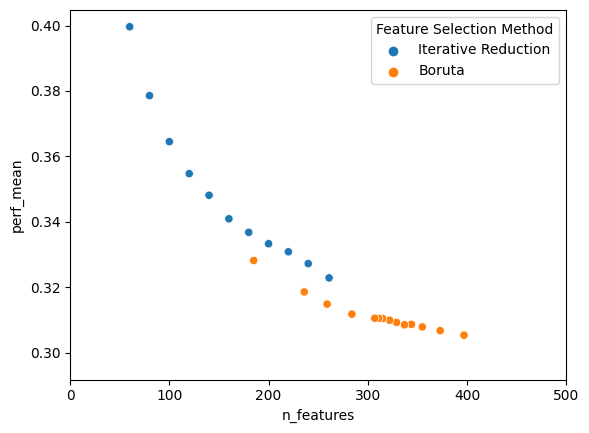

In [17]:
sns.scatterplot(data=plot_df,x='n_features',y='perf_mean',hue='Feature Selection Method')
plt.xlim(0, 500)
plt.show()